<a href="https://colab.research.google.com/github/TapirandKapibara/themachinelearning/blob/main/29072022_Expirement_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimizer sgd. 

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import joblib
from keras import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras

In [3]:
df = pd.read_csv("/content/drive/MyDrive/data_folder/energy_GC_data.csv")
df = df.drop("Unnamed: 0", axis = 1)
df.head()

,sequence,label,energy,GC_content
0,acagaagcaacggaagaagcacataaatattcttatgaggtccaac...,1,-4.8,40.0
1,cggacataaagagagtcctccttatgatgattatatacctcaacgc...,1,-5.7,38.0
2,ccaaaagtggaagtaaatccatgtgaaatagtaaacacactattta...,1,-8.5,32.0
3,tcgacaaactgttctgatgataatgaaggtacgaaatgtctaaaat...,1,-4.3,32.0
4,gatggatggagtgcgcaggacgtaaaagattttacatatgagaaca...,1,-2.7,44.0


In [4]:
sequence = list(df.loc[:, 'sequence'])
encoded_list = []

In [5]:
def encode_seq(s):
    Encode = {'a':[1,0,0,0],'t':[0,1,0,0],'c':[0,0,1,0],'g':[0,0,0,1]}
    return [Encode[x] for x in s]

for i in sequence:
    x = encode_seq(i)
    encoded_list.append(x)

X = np.array(encoded_list)
X.shape

(26467, 50, 4)

In [6]:
y = df['label']
y.shape

(26467,)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [8]:
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [9]:
params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32], 
    'dropout': [0.1, 0.2, 0.5]
}

In [11]:
gru_model = Sequential()

gru_model.add(Conv1D(filters = 27, kernel_size = (4), activation = 'relu', input_shape = (50, 4)))
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Dropout(0.2))
gru_model.add(Conv1D(filters = 14, kernel_size = (2), activation = 'relu', padding = 'same'))
gru_model.add(Bidirectional(GRU(128, activation = 'relu')))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
gru_model.add(Dense(2, activation = 'sigmoid'))

gru_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )
history = gru_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=1000)

Epoch 1/1000
156/156 [==============================] - 10s 49ms/step - loss: 0.9438 - accuracy: 0.4998 - val_loss: 0.9353 - val_accuracy: 0.5122
Epoch 2/1000
156/156 [==============================] - 7s 47ms/step - loss: 0.9281 - accuracy: 0.5115 - val_loss: 0.9200 - val_accuracy: 0.5321
Epoch 3/1000
156/156 [==============================] - 7s 47ms/step - loss: 0.9134 - accuracy: 0.5298 - val_loss: 0.9057 - val_accuracy: 0.6189
Epoch 4/1000
156/156 [==============================] - 7s 48ms/step - loss: 0.8996 - accuracy: 0.5624 - val_loss: 0.8923 - val_accuracy: 0.6293
Epoch 5/1000
156/156 [==============================] - 7s 47ms/step - loss: 0.8866 - accuracy: 0.5742 - val_loss: 0.8795 - val_accuracy: 0.5926
Epoch 6/1000
156/156 [==============================] - 8s 51ms/step - loss: 0.8743 - accuracy: 0.5867 - val_loss: 0.8675 - val_accuracy: 0.6344
Epoch 7/1000
156/156 [==============================] - 7s 47ms/step - loss: 0.8627 - accuracy: 0.6047 - val_loss: 0.8561 - val_a

In [12]:
pred_y=gru_model.predict(X_test) 
classes_y_pred=np.argmax(pred_y,axis=1)

In [13]:
classes_y_pred
len(classes_y_pred)

6617

In [14]:
classes_x_real=np.argmax(y_test,axis=1)

In [15]:
classes_x_real

array([1, 0, 1, ..., 0, 0, 1])

In [16]:
y_test.shape

(6617, 2)

In [17]:
df_one = pd.DataFrame(classes_x_real, columns = ["labels"])
df_one.head()

,labels
0,1
1,0
2,1
3,1
4,0


In [18]:
df_two = pd.DataFrame(classes_y_pred, columns = ["predicted"])
df_two.head()

,predicted
0,0
1,1
2,1
3,1
4,0


In [19]:
df3 = pd.concat([df_one, df_two], axis=1)

In [20]:
df3

,labels,predicted
0,1,0
1,0,1
2,1,1
3,1,1
4,0,0
...,...,...
6612,1,0
6613,0,1
6614,0,1
6615,0,0


In [21]:
df3['comparison'] = np.where(df3['labels'] == df3['predicted'],
                                 'True', 'False') 


In [22]:
df3

,labels,predicted,comparison
0,1,0,False
1,0,1,False
2,1,1,True
3,1,1,True
4,0,0,True
...,...,...,...
6612,1,0,False
6613,0,1,False
6614,0,1,False
6615,0,0,True


In [23]:
the_falses = df3['comparison'].value_counts()['False']

In [24]:
100-(the_falses/6617*100)

74.80731449297265

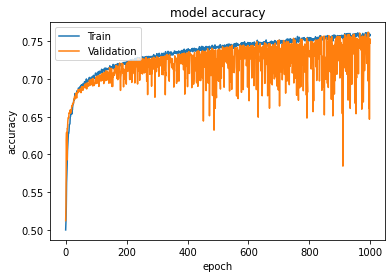

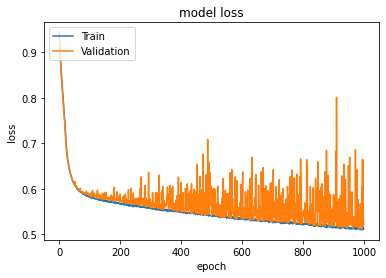

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
X_test.shape

(6617, 50, 4)

In [ ]:
X_islist = X_test.tolist()

In [ ]:
len(X_islist)

6617

In [ ]:
X_islist

[[[1, 0, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 0, 1],
  [0, 0, 0, 1],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 1, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1],
  [1, 0, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 0, 1],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 1, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 1, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0],
  [0, 1, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1],
  [1, 0, 0, 0],
  [1, 0, 0, 0],
  [0, 1, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [0, 0, 1, 0],
  [0, 0, 0, 1],
  [0, 1, 0, 0],
  [0, 0, 1, 0]],
 [[0, 1, 0, 0],
  [0, 0, 0, 1],
  [0, 0, 0, 1],
  [0, 1, 0, 0],
  [0, 1, 0, 0],
  [1, 0, 0, 0],
  [0, 0, 1, 0],
  [1, 0, 0, 0],
  [0, 1, 0, 0],
  [0, 0, 0, 1],
  [1, 0, 0, 0],
  [0, 0, 0, 1],
  [0, 1

In [ ]:
the_list = []
for k in X_islist:
  a = ""
  for i in k:
    if i == [1,0,0,0]:
      a += "a"
    elif i == [0,1,0,0]:
      a += "t"
    elif i == [0,0,1,0]:
      a += "c"
    elif i == [0,0,0,1]:
      a += "g"
  the_list.append(a)

      



In [ ]:
print(the_list)
len(the_list)

['aaggcacatacgaaagcacatacacaacccaatacgaataccacaccgtc', 'tggttacatgagtggggaagcgacttttgtggtaaaaggaaacggatgtt', 'atacacaaaagaaataacaagtggtggtgctagtggtggtcgtagtggta', 'gtgatgctggacagaaagatacatatttcaaaacatcaagtggcggtgaa', 'tgaaatccccccccatagtgatgaaaccctcgaggaacaaaccgacgacg', 'gacttcgtgtggtcttaatggcgctgataactcaaaagaggttaaaaagg', 'ataaatataaaaatttttgtgcaaatggtgaaaaaagtgcaactggtact', 'gtgctgcaaaagaaattcattttttatggaaaaaatatgaagatgataaa', 'agaagaagaagaagatgaagtcgaggcggcgtcggaggaaaccgtcgagg', 'ataccaccccccaacctgatgaggaagaggaactccttgaagaaacagaa', 'acgaagacgacgaagacttcgaagacgtccccgaggaggatacgccggcg', 'tcacttataggggataataatggaaatactgctattggagggtgcaatac', 'gacgtgtggtacgtagtactcccgaaaccaccacacctagtaatagtggt', 'agacgaataccaatacacaaatgtcaaacttaaagacgaacccagtgaga', 'cgactgttccacaatttatacgctgatatagtagtggtgatggtgaagat', 'aaacgaagaggcgtgtgaaatagtggatggaatacttgcagggaaaaagg', 'cggagttttgtgataaaaaaaatggagttgccgaagagaacatcaattat', 'attctaaatcacaagaccgtaaaacgtggtggaattcaattgaaaaagag', 'gagaaggataaccaaattaaaaattg

6617

In [ ]:
df_4 = pd.DataFrame(the_list, columns = ["sequences"])

In [ ]:
df_4.head()

,sequences
0,aaggcacatacgaaagcacatacacaacccaatacgaataccacac...
1,tggttacatgagtggggaagcgacttttgtggtaaaaggaaacgga...
2,atacacaaaagaaataacaagtggtggtgctagtggtggtcgtagt...
3,gtgatgctggacagaaagatacatatttcaaaacatcaagtggcgg...
4,tgaaatccccccccatagtgatgaaaccctcgaggaacaaaccgac...


In [ ]:
df5 = pd.concat([df_4, df3], axis=1)

In [ ]:
df5.head(10)

,sequences,labels,predicted,comparison
0,aaggcacatacgaaagcacatacacaacccaatacgaataccacac...,1,1,True
1,tggttacatgagtggggaagcgacttttgtggtaaaaggaaacgga...,0,0,True
2,atacacaaaagaaataacaagtggtggtgctagtggtggtcgtagt...,1,1,True
3,gtgatgctggacagaaagatacatatttcaaaacatcaagtggcgg...,1,1,True
4,tgaaatccccccccatagtgatgaaaccctcgaggaacaaaccgac...,0,0,True
5,gacttcgtgtggtcttaatggcgctgataactcaaaagaggttaaa...,0,1,False
6,ataaatataaaaatttttgtgcaaatggtgaaaaaagtgcaactgg...,1,1,True
7,gtgctgcaaaagaaattcattttttatggaaaaaatatgaagatga...,1,1,True
8,agaagaagaagaagatgaagtcgaggcggcgtcggaggaaaccgtc...,1,0,False
9,ataccaccccccaacctgatgaggaagaggaactccttgaagaaac...,1,1,True


In [ ]:
df5.to_csv("/content/drive/MyDrive/data_folder/selecteddata.csv")


https://www.kaggle.com/code/zakarii/dna-sequence-classification-cnn-gru/notebook